# Reads an image from a webcam, sends to the cloud (MS Cognitive Services) and returns the emotions.

Based on https://github.com/Microsoft/Cognitive-emotion-python

In [1]:
import cv2
import time
import os

# https://github.com/ricardodeazambuja/Webcam2HTTP
from Webcam2HTTP import snapshot_generator

In [7]:
#
# Testing snapshot_generator
#

import numpy
import matplotlib.pyplot as plt
%matplotlib inline

snp = snapshot_generator()

Device initialised, ready to capture!


In [11]:
img = snp() # In my laptop, the camera takes a while until it adapts 
            # to the lighting conditions and a second shot is always necessary...

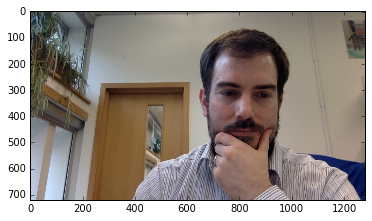

In [12]:
plt.imshow(cv2.imdecode(numpy.frombuffer(img,dtype = numpy.uint8), cv2.cv.CV_LOAD_IMAGE_COLOR))
plt.show()

In [13]:
snp(False)

Device closed, exiting...


0

In [14]:
# Variables

_url = 'https://westus.api.cognitive.microsoft.com/emotion/v1.0/recognize'
_maxNumRetries = 10


_key = 'b09b328a70034eb1ac4ccf07450fea29' #Here you have to paste your primary key (mine is invalid now...)

## Helper functions

In [15]:
import time 
import requests

def processRequest( json, data, headers, params ):

    """
    Helper function to process the request to Project Oxford

    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """

    retries = 0
    result = None

    while True:

        response = requests.request( 'post', _url, json = json, data = data, headers = headers, params = params )

        if response.status_code == 429: 

            print( "Message: %s" % ( response.json()['error']['message'] ) )

            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break

        elif response.status_code == 200 or response.status_code == 201:

            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None 
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json()['error']['message'] ) )

        break
        
    return result

In [16]:
import cv2
import operator

def renderResultOnImage( result, img ):
    
    """Display the obtained results onto the input image"""
    
    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        cv2.rectangle( img,(faceRectangle['left'],faceRectangle['top']),
                           (faceRectangle['left']+faceRectangle['width'], faceRectangle['top'] + faceRectangle['height']),
                       color = (255,0,0), thickness = 5 )


    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        currEmotion = max(currFace['scores'].items(), key=operator.itemgetter(1))[0]


        textToWrite = "%s" % ( currEmotion )
        cv2.putText( img, textToWrite, (faceRectangle['left'],faceRectangle['top']-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1 )

# Detect faces from a webcam

Device initialised, ready to capture!
[{u'faceRectangle': {u'width': 249, u'top': 242, u'left': 559, u'height': 249}, u'scores': {u'sadness': 5.268689e-06, u'neutral': 0.06345575, u'contempt': 0.000244121868, u'disgust': 1.82709312e-06, u'anger': 7.482331e-07, u'surprise': 2.94836127e-06, u'fear': 7.176368e-09, u'happiness': 0.9362893}}]
Device closed, exiting...


0

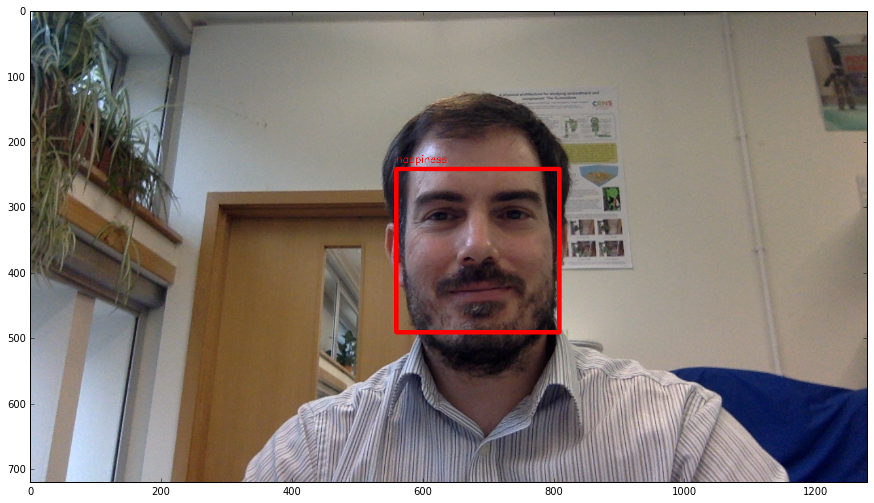

In [18]:
snp = snapshot_generator() # initialises the system

data = snp() # grabs the image from your device

headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key
headers['Content-Type'] = 'application/octet-stream'

json = None
params = None

result = processRequest( json, data, headers, params )

# Debug
print result

if result is not None:
    # Load the original image
    data8uint = numpy.fromstring( data, numpy.uint8 ) # Convert string to an unsigned int array
    img = cv2.imdecode( data8uint, cv2.IMREAD_COLOR )

    renderResultOnImage( result, img )

    ig, ax = plt.subplots(figsize=(15, 20))
    ax.imshow( img )
    

snp(False) # closes the device